# Spam Email Classification Using GRU

## Data Loading

In [1]:
# Setup for kaggle API

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
# Downloading dataset via Kaggle

!kaggle datasets download -d purusinghvi/email-spam-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset
License(s): MIT
 95% 41.0M/43.0M [00:00<00:00, 121MB/s]
100% 43.0M/43.0M [00:00<00:00, 107MB/s]


In [3]:
# Extracting data from ZipFile

import zipfile
zipfile_ref = zipfile.ZipFile('/content/email-spam-classification-dataset.zip','r')
zipfile_ref.extractall('/content')
zipfile_ref.close()

## Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('content/combined_data.csv')

In [3]:
df.head(5)

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [13]:
df.shape

(83448, 2)

In [6]:
df.size

166896

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


In [8]:
df.describe()

,label
count,83448.000000
mean,0.526196
std,0.499316
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [9]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [10]:
df.isna().sum()

label    0
text     0
dtype: int64

In [11]:
df.duplicated().sum()

np.int64(0)

## Data Visualization

In [3]:
# Creating a duplicate dataframe for data visualization

df_dv = df.copy()

In [15]:
# Labelling Spam or Ham

df_dv.rename(columns={'text': 'Text', 'label': 'Label'}, inplace=True)
df_dv['Label'] = df_dv['Label'].replace({
    0: 'Ham',
    1: 'Spam',
})

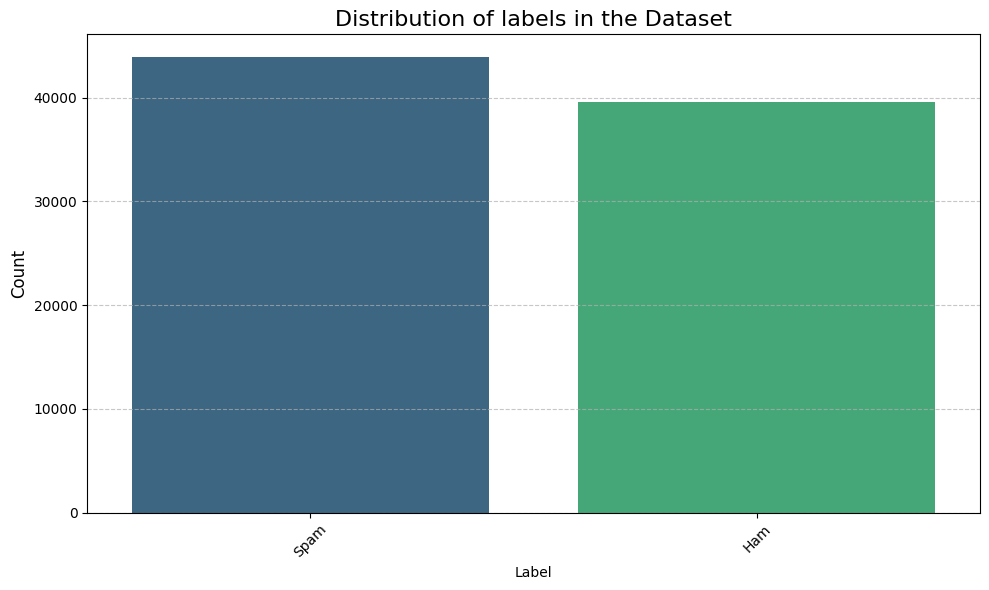

In [16]:
# Visualizing Distribution of Labels

label_counts = df_dv['Label'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of labels in the Dataset', fontsize=16)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

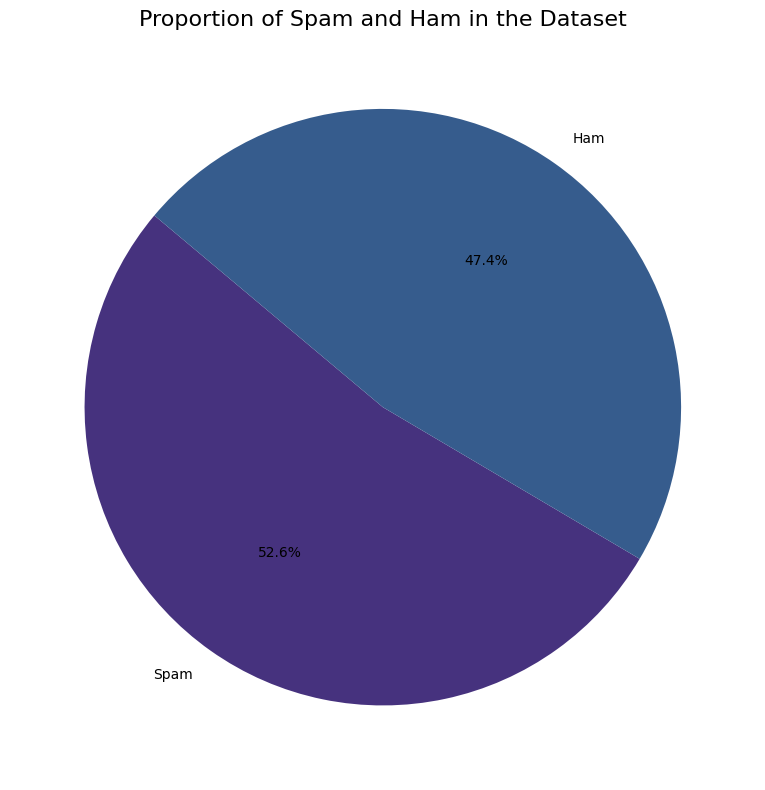

In [15]:
# Visualizing Label Distribution

plt.figure(figsize=(8, 8))

df_dv['Label'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis'))
plt.title('Proportion of Spam and Ham in the Dataset', fontsize=16)
plt.ylabel('')
plt.tight_layout()
plt.show()

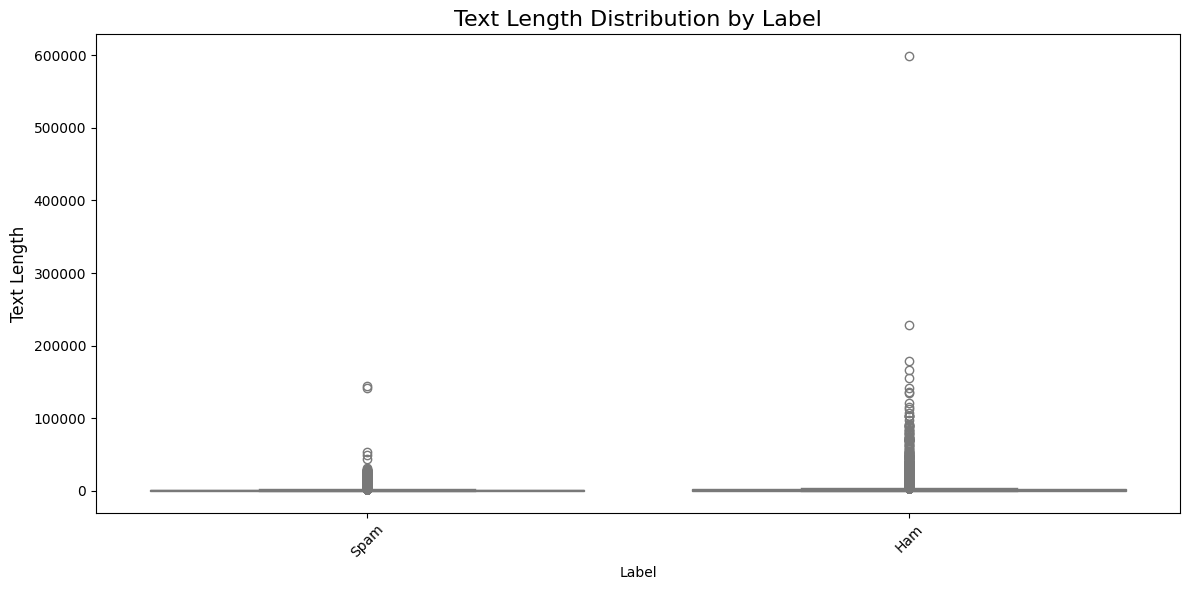

In [16]:
# Representing Text Length Distribution by Labels

df_dv['Text_Length'] = df_dv['Text'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Text_Length', data=df_dv, palette='coolwarm')
plt.title('Text Length Distribution by Label', fontsize=16)
plt.ylabel('Text Length', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

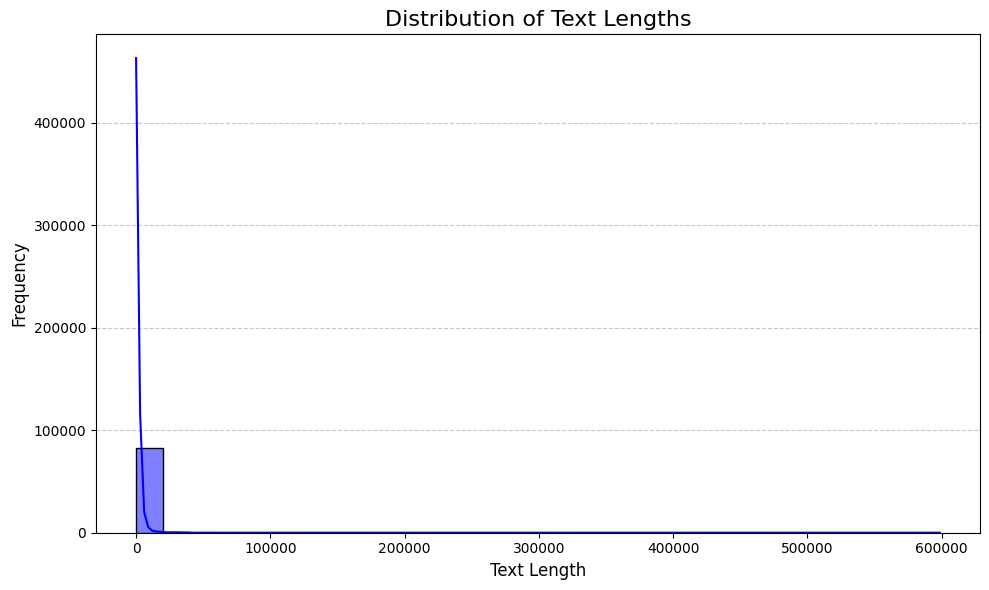

In [17]:
# Plotting Histogram for Distributon of Text Lengths

plt.figure(figsize=(10, 6))
df_dv['Text_Length'] = df_dv['Text'].apply(len)
sns.histplot(df_dv['Text_Length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Text Lengths', fontsize=16)
plt.xlabel('Text Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

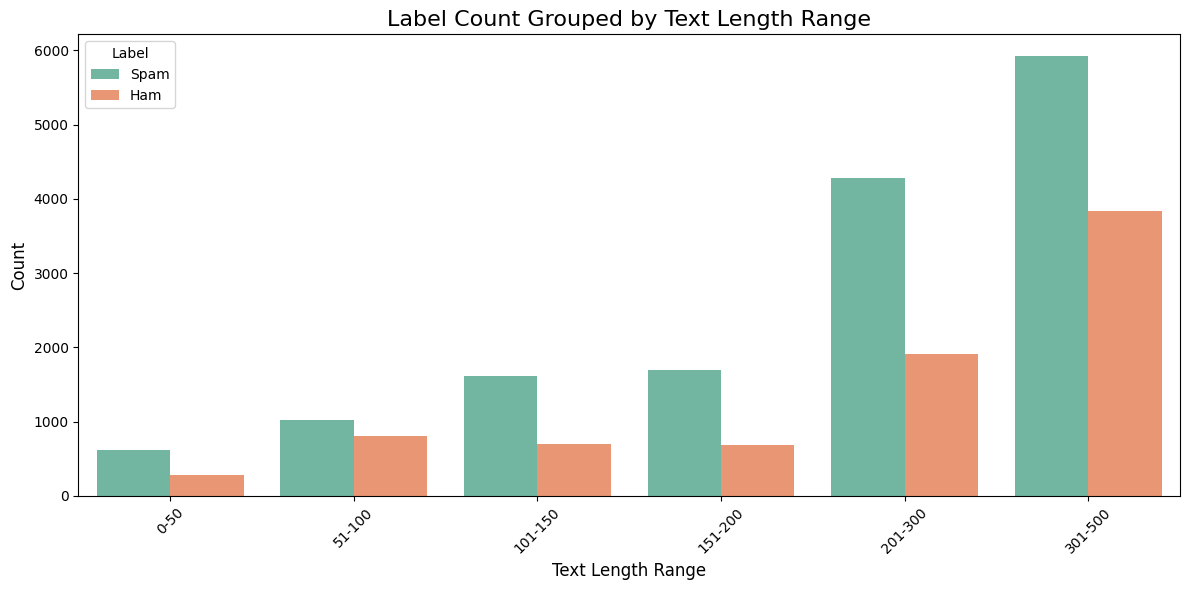

In [18]:
# Visualizing Label Count Grouped by Text Length Range

df_dv['Length_Bin'] = pd.cut(df_dv['Text_Length'], bins=[0, 50, 100, 150, 200, 300, 500],
                          labels=['0-50', '51-100', '101-150', '151-200', '201-300', '301-500'])

plt.figure(figsize=(12, 6))
sns.countplot(x='Length_Bin', hue='Label', data=df_dv, palette='Set2')
plt.title('Label Count Grouped by Text Length Range', fontsize=16)
plt.xlabel('Text Length Range', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

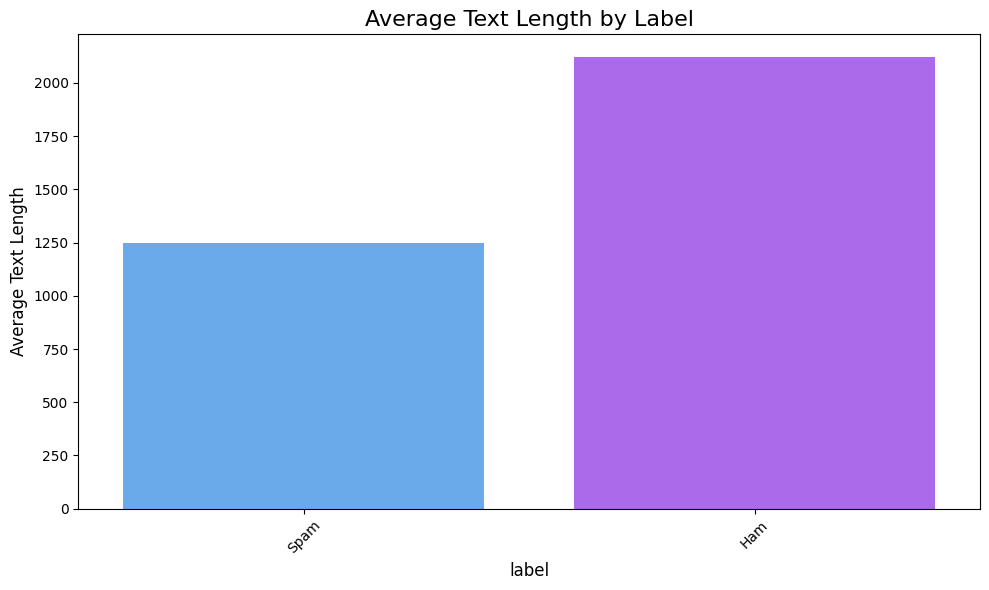

In [19]:
# Visualizing Average Text Length by label

avg_text_length = df_dv.groupby('Label')['Text_Length'].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_text_length.index, y=avg_text_length.values, palette='cool')
plt.title('Average Text Length by Label', fontsize=16)
plt.xlabel('label', fontsize=12)
plt.ylabel('Average Text Length', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

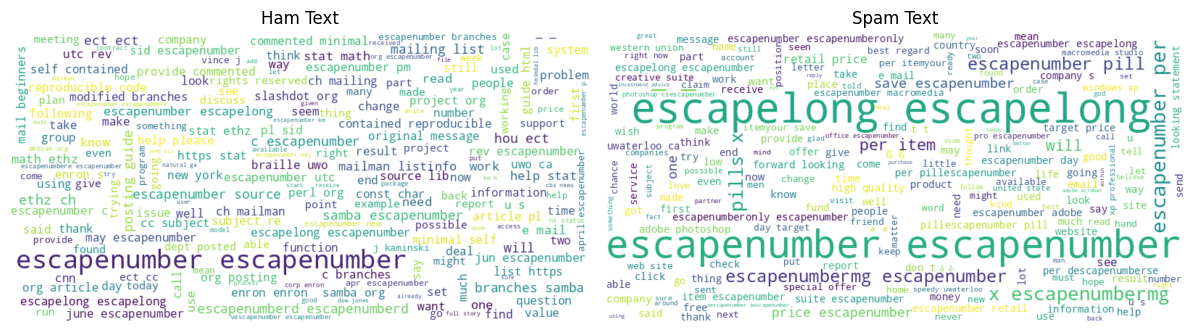

In [17]:
# Creating WordCloud for all the lables

from wordcloud import WordCloud

emotion_dfs = {
    'Ham': df_dv[df_dv['Label'] == 'Ham'],
    'Spam': df_dv[df_dv['Label'] == 'Spam'],
}

plt.figure(figsize=(18, 9))
for i, (emotion, subset) in enumerate(emotion_dfs.items(), 1):
    combined_text = ' '.join(subset['Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

    plt.subplot(2, 3, i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{emotion} Text')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Data Cleaning & Preprocessing

In [49]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow import keras
import tensorflow
nltk.download('stopwords')
print(tensorflow.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pacelino/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
# Creating a pipeline for Data Cleaning

def clean_text_pipeline(df, text_column='Text'):
    stop = set(stopwords.words('english'))

    def clean_text(text):
        text = re.sub(r'http\S+|www\S+|@\S+', '', text)  # Removing URLs and email addresses
        text = re.sub(r'[^\w\s]', '', text)        # Removing special characters and punctuation
        text = re.sub(r'\s+', ' ', text)           # Removing extra whitespaces
        text = text.lower()                        # Lowercasing text

        df[text_column] = df[text_column].apply(clean_text)
    return df

In [51]:
# Data Cleaning

df = clean_text_pipeline(df, text_column='Text')

In [52]:
# Train Test And Split

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# Tokenization and Padding

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

tokenizer = Tokenizer(num_words=200)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

maxlen = max(len(tokens) for tokens in X_train_sequences)

X_train_padded =  keras.preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=300, padding='post', truncating='post')
X_test_padded =  keras.preprocessing.sequence.pad_sequences(X_test_sequences, maxlen=300, padding='post', truncating='post')

## Model Training

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

In [55]:
model = Sequential()
model.add(Embedding(8000, 100, input_length=100))
model.add(GRU(16))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow import keras


model = keras.Sequential()
model.add(keras.layers.Embedding(8000, 100, input_length=300)) 
model.add(keras.layers.GRU(16))
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    X_train_padded,
    y_train,
    validation_data=(X_test_padded, y_test),
    epochs=5,
    batch_size=16
)


Epoch 1/5


2025-10-16 00:46:42.243631: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


4173/4173 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - accuracy: 0.7832 - loss: 0.4078 - val_accuracy: 0.9343 - val_loss: 0.1712
Epoch 2/5
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - accuracy: 0.9452 - loss: 0.1448 - val_accuracy: 0.9560 - val_loss: 0.1142
Epoch 3/5
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.9593 - loss: 0.1079 - val_accuracy: 0.9631 - val_loss: 0.0981
Epoch 4/5
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - accuracy: 0.9664 - loss: 0.0910 - val_accuracy: 0.9677 - val_loss: 0.0833
Epoch 5/5
4173/4173 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.9710 - loss: 0.0802 - val_accuracy: 0.9666 - val_loss: 0.0900


In [ ]:
import json
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.utils import pad_sequences


MAXLEN = 300 
MODEL_PATH = 'spam_model.keras'
TOKENIZER_PATH = 'spam_tokenizer.json'


try:
    model.save(MODEL_PATH)
    print(f"✅ Модель сохранена: {MODEL_PATH}")
except NameError:
    print("❌ Ошибка: Переменная 'model' не найдена.")

# 1.2. Сохранение Токенизатора
try:
    tokenizer_json = tokenizer.to_json()
    with open(TOKENIZER_PATH, 'w', encoding='utf-8') as f:
        json.dump(tokenizer_json, f)
    print(f"Токенизатор сохранен: {TOKENIZER_PATH}")
except NameError:
    print("Ошибка: Переменная 'tokenizer' не найдена.")


# 2.1. Загрузка Модели
loaded_model = keras.models.load_model(MODEL_PATH)

# 2.2. Загрузка Токенизатора
with open(TOKENIZER_PATH, 'r', encoding='utf-8') as f:
    json_data = json.load(f)
loaded_tokenizer = tokenizer_from_json(json_data)

# 2.3. Новые данные для прогноза
X_new = np.array([
    "Free gift card now! Claim your prize before midnight.", # Спам
    "Check out the meeting notes from yesterday's sync-up."  # Не спам
])


X_seq = loaded_tokenizer.texts_to_sequences(X_new)
X_pad = pad_sequences(X_seq, maxlen=MAXLEN, padding='post', truncating='post')


predictions = loaded_model.predict(X_pad)
predicted_classes = np.argmax(predictions, axis=1)


for text, prob, cls in zip(X_new, predictions, predicted_classes):
    label = "СПАМ" if cls == 1 else "НЕ СПАМ"
    print(f"\nТекст: '{text}'")
    print(f"Прогноз: {label} (Вероятность Спама: {prob[1]:.4f})")

✅ Модель сохранена: spam_model.keras
✅ Токенизатор сохранен: spam_tokenizer.json

--- ЗАПУСК СОХРАНЕННОЙ МОДЕЛИ ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

Текст: 'Free gift card now! Claim your prize before midnight.'
Прогноз: 🔥 СПАМ (Вероятность Спама: 0.9959)

Текст: 'Check out the meeting notes from yesterday's sync-up.'
Прогноз: 🔥 СПАМ (Вероятность Спама: 0.9254)


## Model Prediction

In [60]:
history_df=pd.DataFrame(history.history)
history_df

,accuracy,loss,val_accuracy,val_loss
0,0.783247,0.407826,0.934332,0.171191
1,0.945160,0.144795,0.956022,0.114213
2,0.959256,0.107878,0.963092,0.098100
3,0.966431,0.090998,0.967705,0.083302
4,0.970955,0.080202,0.966627,0.090004


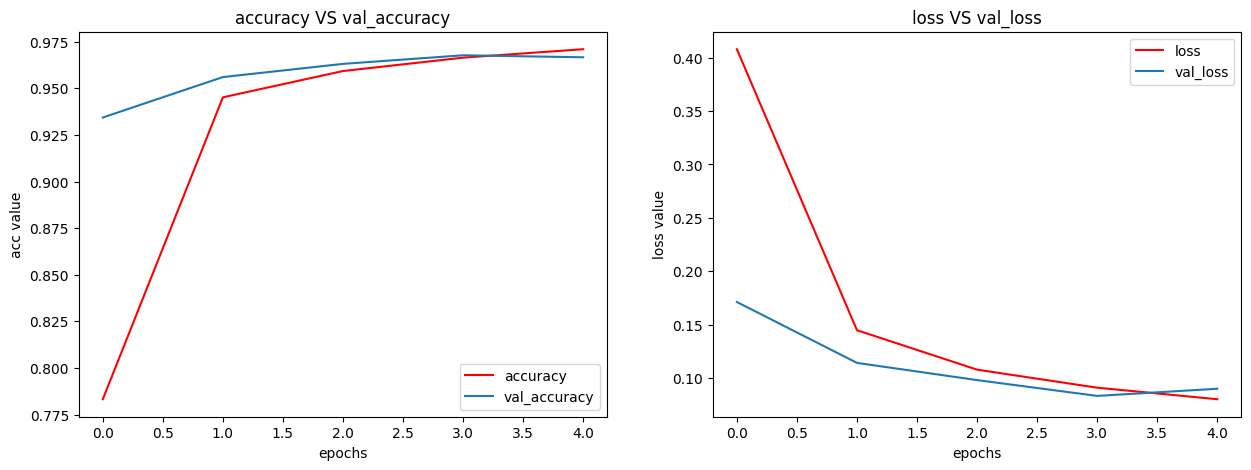

In [61]:
plt.figure(figsize=(15,5))

# plotting accuracy and val_accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'],label='accuracy',c='red')
plt.plot(history_df['val_accuracy'],label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('acc value')
plt.title('accuracy VS val_accuracy')
plt.legend()

# plotting loss and val_loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'],label='loss',c='red')
plt.plot(history_df['val_loss'],label='val_loss')
plt.title('loss VS val_loss')
plt.xlabel('epochs')
plt.ylabel('loss value')
plt.legend()

plt.show()

522/522 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


<Axes: >

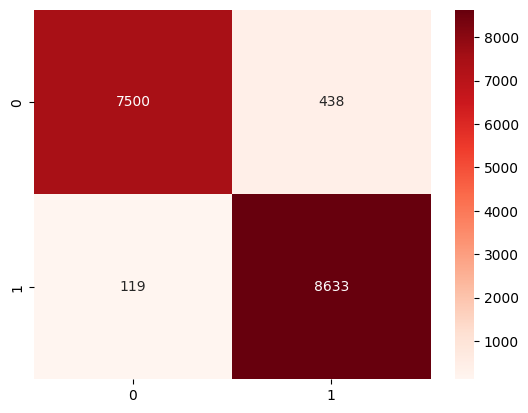

In [62]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')